```yaml
#%mldev nb_context

pipeline:
  - imports
  - params
  - def_funcs
  - def_funcs_2
  - fig_1
  - plt_1
  - def_moving_average
  - tx
  - fig_2
  - acf
  - fig_3
  - T_one_step
  - plot_2
  - fs_fig
  - scales_fig
  - accel_ssa
  - plot_3
  - fig_4
  - fig_5
  - fig_6
  - fig_7
  - scaleogram_fig
  - plot_phase_track
  - phase_track
  - plot_phase_track_2
  - Sphere_projection
  - eigenvalues_plot
  - eigenvalues_plot_2
  - phase_track5
  - norming
  - sphere_data
  - track_mean
  - def_to_spherical
  - fig_8
  - dispers
  - fig_9
  - install_pyshtools
  - import_3
  - sph_harm_transform
  - f
  - plot_4
  - npic
  - a
  - a_zeros
  - add_some_ones
  - plot_5
  - imports_4
  - wx
  - grid_fig
  - xmeanstd
  - phase_track_6
  - phase_track_4
  - XHANkel
  - pred_x
  - dr_trajectory
  - fig_10
  - Sphere_projection_3

```

___
# Initial analysis

In [ ]:
!pip install scaleogram
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import *
import scipy.linalg


import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

#%mldev imports

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

#%mldev params

In [ ]:
def HankelMatrix(X, L):
    
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def matpower(a, alpha):
    a = (a + a.T) / 2
    eigenValues, eigenVectors = np.linalg.eig(a)
    return np.dot(np.dot(eigenVectors, np.diag(eigenValues ** alpha)), eigenVectors.T)

# Sufficient dimension reduction problem:
# X ~ R^p
# Y ~ R
# Y depends only on beta^T X
# beta: p x r

def directional_regression(x, y, h, r):
    np.random.seed(200)
    # x[i, j] = i'th object, j'th feature

    # number of objects
    n = x.shape[0]
    # dimension to reduce, r is target dimension, r <= p
    p = x.shape[1]

    r_var = np.cov(x.T)

    signrt = matpower(r_var, -0.5)

    #xst = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    xst = np.dot(x - np.mean(x, axis=0), signrt)

    #bin_count = 10
    hist = np.histogram(y, bins=h)
    y_bins = np.fmin(np.digitize(y, hist[1]), h) - 1

    prob = np.zeros(h)
    for i in range(h):
        prob[i] = np.sum(y_bins == i) / n
        
    vxy = np.zeros((p, p, h))
    exy = np.zeros((h, p))
    for i in range(h):
        vxy[:,:,i] = np.cov(xst[y_bins == i, :].T)
        exy[i,:] = np.mean(xst[y_bins == i, :], axis=0)

    mat1 = np.zeros((p, p))
    mat2 = np.zeros((p, p))

    for i in range(h):
#         print("i =", i)
        A = exy[i,:][:,np.newaxis].dot(exy[i,:][:,np.newaxis].T)
        B = vxy[:,:,i] + A
        
#         print('vxy:', vxy[:,:,i])
#         print("B:", B)
        mat1 += prob[i] * B.dot(B)
        mat2 += prob[i] * A

    out = 2 * mat1 + 2 * mat2.dot(mat2) + 2 * np.sum(np.diag(mat2))*mat2 - 2 * np.eye(p)
    
    
#     print("prob:", prob)
#     print("mat1:", mat1)
    
    eigenValues, eigenVectors = np.linalg.eig(out)

    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    output = np.zeros((n, r))

    for i in range(r):
        u = eigenVectors[i,:]
#         print('Eigen vector {}'.format(u))
        output[:, i] = u.dot(x.T)

    return output

def ApplyDR(trajectory, r=2, h=30):
    y = trajectory[:, -1]
    X = trajectory[:, :-1]
    
    pred = directional_regression(X, y, h, r)
    return pred

def add_free(X):
    return np.hstack([X, np.ones(shape=(X.shape[0], 1))])

def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return np.array(new_ts)

#%mldev def_funcs

In [ ]:
def sph_harm_to_shtools(c):
    """ Convert our list format for the sph harm coefficients/harmonics to pyshtools (2, n, n) format. """
    n = len(c)
    real = is_real_sft(c)
    dim1 = 1 if real else 2
    out = np.zeros((dim1, n, n, *c[0][0].shape)) + 0j
    for l, cc in enumerate(c):
        cc = np.array(cc)
        if not real:
            m_minus = cc[:l][::-1]
            m_plus = cc[l:]
        else:
            m_minus = np.array([])
            m_plus = cc

        # we get warnings here when using reals
        if m_minus.size > 0:
            out[1, l, 1:l+1, ...] = m_minus
        out[0, l, :l+1, ...] = m_plus

    return out

def sph_sample(n, mode='DH'):
    """ Sample grid on a sphere.
    Args:
        n (int): dimension is n x n
        mode (str): sampling mode; DH or GLQ
    Returns:
        theta, phi (1D arrays): polar and azimuthal angles
    """
    assert n % 2 == 0
    j = np.arange(0, n)
    if mode == 'DH':
        return j*np.pi/n, j*2*np.pi/n
    elif mode == 'ours':
        return (2*j+1)*np.pi/2/n, j*2*np.pi/n
    elif mode == 'GLQ':
        from pyshtools.shtools import GLQGridCoord
        phi, theta = GLQGridCoord(n-1)
        # convert latitude to [0, np.pi/2]
        return np.radians(phi+90), np.radians(theta)
    elif mode == 'naive':
        # repeat first and last points; useful for plotting
        return np.linspace(0, np.pi, n), np.linspace(0, 2*np.pi, n)

def DHaj(n, mode='DH'):
    """ Sampling weights. """
    # Driscoll and Healy sampling weights (on the phi dimension)
    # note: weights depend on the chosen grid, given by sph_sample
    if mode == 'DH':
        gridfun = lambda j: np.pi*j/n
    elif mode == 'ours':
        gridfun = lambda j: np.pi*(2*j+1)/2/n
    else:
        raise NotImplementedError()

    l = np.arange(0, n/2)
    a = [(2*np.sqrt(2)/n *
          np.sin(gridfun(j)) *
          (1/(2*l+1) * np.sin((2*l+1)*gridfun(j))).sum())
         for j in range(n)]

    return a


def sph_harm_all(n, as_tfvar=False, real=False):
    """ Compute spherical harmonics for an n x n input (degree up to n // 2)
    Args:
        n (int): input dimensions; order will be n // 2
        as_tfvar (bool): if True, return as list of tensorflow Variables.
        real (bool): if True, return real harmonics
    """
    harmonics = []

    for l in range(n // 2):
        if real:
            minl = 0
        else:
            minl = -l
        row = []
        for m in range(minl, l+1):
            row.append(sph_harm_lm(l, m, n))
        harmonics.append(row)

    else:
        return harmonics
    
def sph_harm_lm(l, m, n):
    """ Wrapper around scipy.special.sph_harm. Return spherical harmonic of degree l and order m. """
    phi, theta = sph_sample(n)
    phi, theta = np.meshgrid(phi, theta)
    f = sph_harm(m, l, theta, phi)

    return f

def is_real_sft(h_or_c):
    """ Detect if list of lists of harmonics or coefficients assumes real inputs (m>0) """
    d = len(h_or_c[1])

    isreal = True if d == 2 else False

    return isreal

#%mldev def_funcs_2

___
# Choose first 10 steps
## Common walking, phone accelerometer
### Frequency 0.91$\pm$1 s was found empirically

In [ ]:
dt = 459*20
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3815+6*455:3815+6*455+dt]
data = pd.read_csv('long_walk_100_acc.csv', delimiter =';', decimal=',')[7009:7009+dt]
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3785:8000]
#data = pd.read_csv('data/home_lin_10_lac.csv', delimiter =';', decimal=',')[:]
frecuency = len(data)/(data['time'].values[-1]-data['time'].values[0])
assert 480 < frecuency < 520

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
x_acc -= _m
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

#%mldev fig_1

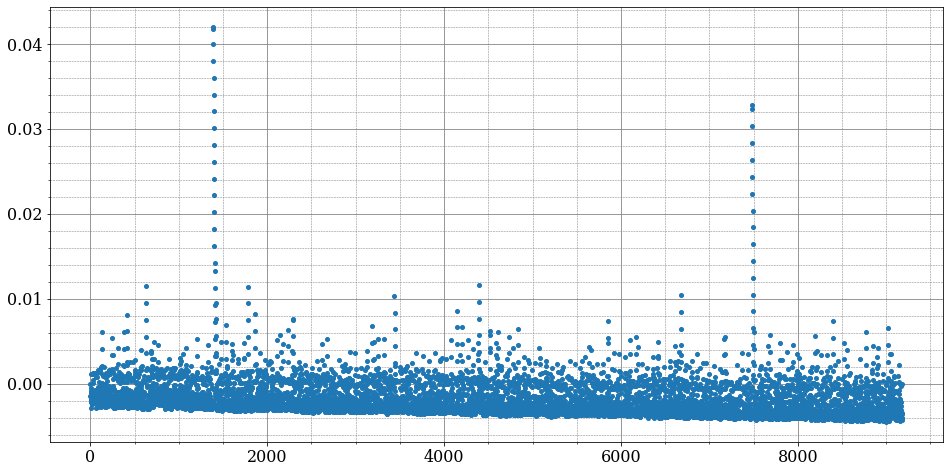

In [ ]:
t_real = (data['time'].values).astype(float).reshape([-1,])
t_real = t_real - t_real[0]

plt.plot(t_real-t,'.')
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

#%mldev plt_1

In [ ]:
_m

10.792185704435663

___
# Velocity figure

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#%mldev def_moving_average

In [ ]:
_t,_x = integ(t,x_acc)

#%mldev tx

In [ ]:
mean_w = 1500

fig = go.Figure()
fig.add_scatter(x = _t[mean_w:], y = (_x)[mean_w:],
                mode='lines', 
                name='Velocity')
fig.add_scatter(x = _t[mean_w:], y = moving_average(_x,mean_w+1),
                mode='lines', 
                name='Velocity')
fig['layout']['yaxis1'].update(title='Velocity[m/s]')
fig['layout']['xaxis1'].update(title='Time[s]')
fig.show()

#%mldev fig_2

___
# Autocorrelation Function


In [ ]:
acf_x = acf(
        x_acc,
        nlags=3000,
        alpha=0.5,
)

#%mldev acf

In [ ]:
fig = go.Figure()
fig.add_scatter(x = np.arange(len(acf_x[0])), y = acf_x[0], mode='lines', name='ACF')
fig.show()

#%mldev fig_3

In [ ]:
np.arange(0,4000,461)

array([   0,  461,  922, 1383, 1844, 2305, 2766, 3227, 3688])

In [ ]:
T_one_step = 460/500
T_one_step

#%mldev T_one_step

0.92

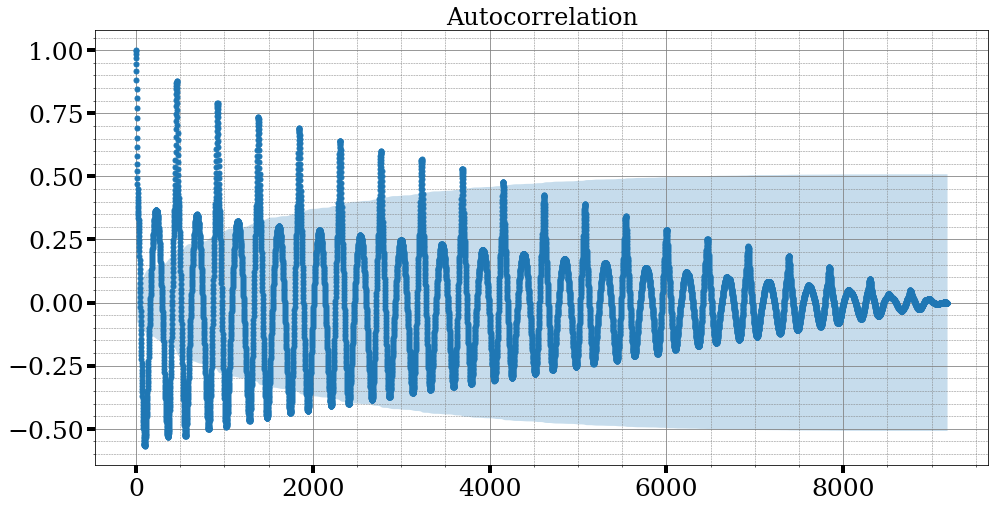

In [ ]:
ax = plot_acf(x_acc,
              lags=len(x_acc)-1,
              use_vlines = False,
              alpha=0.1
         )
plt.tick_params(axis='both', which='major', labelsize=25,length=8, width=4)
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

#%mldev plot_2

# Fast Fourier transforms¶

![image.png](attachment:image.png)

In [ ]:
Fs = 500

N = len(x_acc)

__Abs = 2.0/N * np.abs(fft(x_acc)[0:N//2])

__FS = np.linspace(0.0, 1.0/2.0*Fs, N//2)

# plotting the spectrum
fig = go.Figure()
fig.add_scatter(x = __FS[0:100],
                y = __Abs[0:100],
                mode='lines',
                name='Magnitude'
               )

temp_fft = fft(x_acc)[0:N//2]

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(x = __FS[0:100],
                y = __Ph[0:100],
                mode='markers',
                name='Phase'
               )

fig.add_trace(go.Bar(x= __FS[0:100],
                      y= __Ph[0:100],
                        #mode='markers',
                        name='Phase'
                    )
             )


fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec[1/s]')
fig.show()

#%mldev fs_fig

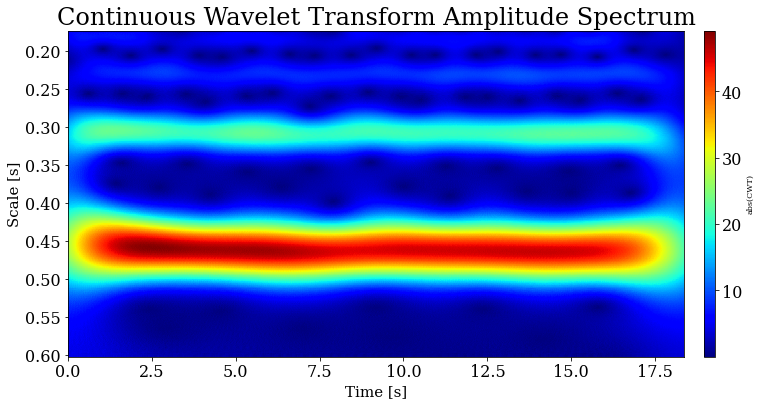

In [ ]:
scales = np.linspace(130,450,500)
ax = scg.cws(t[::1], x_acc, 
             figsize = (12,6),
             scales = scales,
             wavelet = 'cmor6-1.5',
             coi=False
            )
ax.set_ylabel('Scale [s]',fontsize = 15)
ax.set_xlabel('Time [s]',fontsize = 15)
plt.show()

#%mldev scales_fig

# Application of SSA

In [ ]:
accel_ssa = SSA(x_acc, 500)

#%mldev accel_ssa

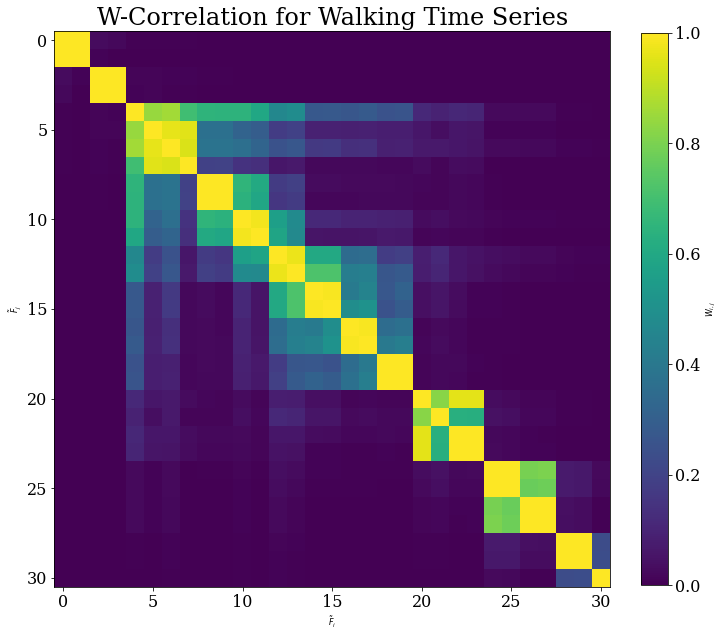

In [ ]:
plt.figure(figsize=(11, 11))
accel_ssa.plot_wcorr(max=30)
plt.title("W-Correlation for Walking Time Series");

#%mldev plot_3

In [ ]:
n_fig = 1000
fig = go.Figure()

fig.add_scatter(x = t[:n_fig], y = x_acc[:n_fig], mode='lines', name='Real')

fig.add_scatter(x = t[:n_fig], y = accel_ssa.reconstruct(slice(0,5))[:n_fig], mode='lines', name='SSA')


x = (4.6*np.cos(2*np.pi*2.18*(t[:n_fig])-.24) + 2.39*np.cos(2*np.pi*3.27*(t[:n_fig])-2.46))

fig.add_scatter(x = t[:n_fig], y = x, mode='lines', name='Main frec')

fig.show()

#%mldev fig_4

# Amplitude modulation

In [ ]:
n_fig = 1000
fig = go.Figure()

x = (4.6*np.cos(2*np.pi*2.18*(t[:n_fig])-.24) + 2.39*np.cos(2*np.pi*3.27*(t[:n_fig])-2.46))/np.cos(2*np.pi*2.18*(t[:n_fig])-.24)

fig.add_scatter(x = t[:n_fig], y = x, mode='lines', name='Main frec')

fig.show()

#%mldev fig_5

In [ ]:
Fs = 500

N = len(x)

__Abs = 2.0/N * np.abs(fft(x)[0:N//2])

__FS = np.linspace(0.0, 1.0/2.0*Fs, N//2)

# plotting the spectrum
fig = go.Figure()
fig.add_scatter(x = __FS[0:30],
                y = __Abs[0:30],
                mode='lines',
                name='Magnitude'
               )

temp_fft = fft(x)[0:N//2]

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(x = __FS[0:30],
                y = __Ph[0:30],
                mode='markers',
                name='Phase'
               )

fig.add_trace(go.Bar(x= __FS[0:30],
                     y= __Ph[0:30],
                        #mode='markers',
                        name='Phase'
                    )
             )


fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec[1/s]')
fig.show()

#%mldev fig_6

___

In [ ]:
fig = go.Figure()
fig.add_scatter(x = t[:], y = accel_ssa.reconstruct(slice(0,4))[:], mode='lines', name='slice')
fig.show()

#%mldev fig_7

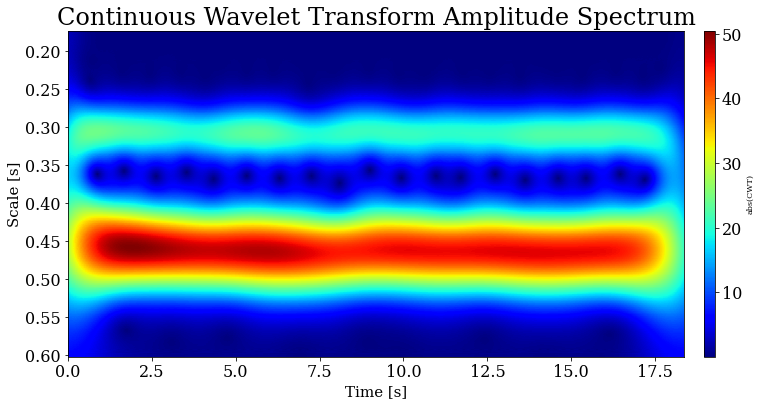

In [ ]:
import scaleogram as scg
scales = np.linspace(130,450,500)
ax = scg.cws(t[::1], accel_ssa.reconstruct(slice(0,4))[::1], 
             figsize = (12,6),
             scales = scales,
             wavelet = 'cmor3-1.5',
             coi=False
            )
ax.set_ylabel('Scale [s]',fontsize = 15)
ax.set_xlabel('Time [s]',fontsize = 15)
plt.show()

#%mldev scaleogram_fig

In [ ]:
x_acc_clear = accel_ssa.reconstruct(slice(0,5))

track1, basis1 = phase_track(np.array([x_acc_clear]).T, 300, 2)

plot_phase_track(track1[:])

#%mldev plot_phase_track

Explained variation for 2 principal components: [0.43827307 0.3808992 ]
Cumulative explained variationfor 2 principal components: 0.819172270655748



In [ ]:
track2, basis2 = phase_track(np.array([x_acc_clear]).T, 300, 3)

#%mldev phase_track

Explained variation for 3 principal components: [0.43827307 0.3808992  0.09921792]
Cumulative explained variationfor 3 principal components: 0.91839019256457



In [ ]:
plot_phase_track(track2)
#%mldev plot_phase_track_2

In [ ]:
Sphere_projection(track2, n = 1)

#%mldev Sphere_projection

No handles with labels found to put in legend.


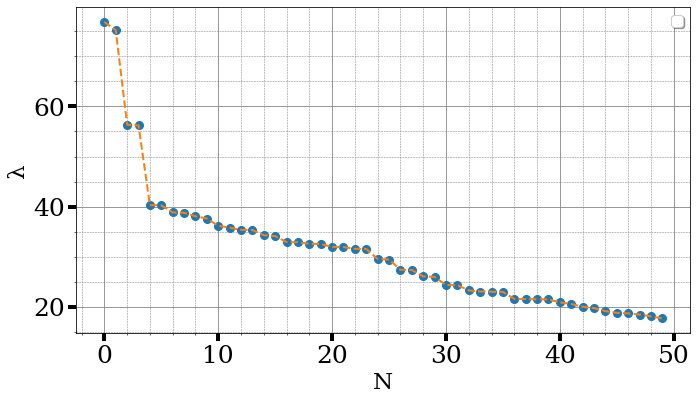

In [ ]:
eigenvalues_plot(x_acc,600,1,num_l = 50,MinMax = False)

#%mldev eigenvalues_plot

No handles with labels found to put in legend.


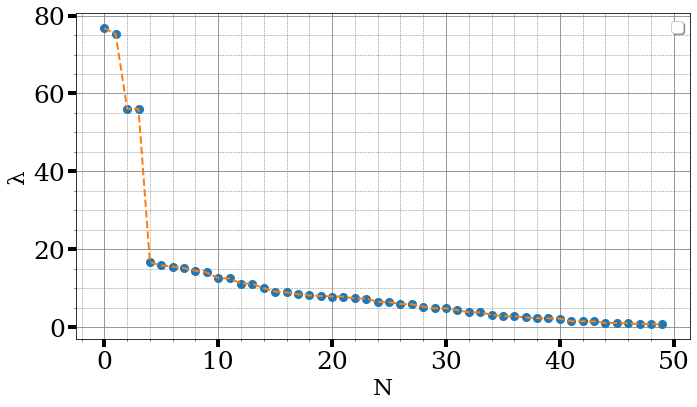

In [ ]:
eigenvalues_plot(x_acc_clear,600,1,num_l = 50)
#%mldev eigenvalues_plot_2

In [ ]:
track5, basis5 = phase_track(np.array([x_acc_clear]).T, 600, 4)
#%mldev phase_track5

Explained variation for 4 principal components: [0.40011295 0.3676284  0.11352861 0.11324896]
Cumulative explained variationfor 4 principal components: 0.9945189233866942



___
# Variance of timeseries

In [ ]:
# нормировка
n = 1
_x = track2[:,0] - track2[:,0].mean()
_y = track2[:,1] - track2[:,1].mean()
_z = track2[:,2] - track2[:,2].mean()

track_norm = np.array([_x,_y,_z]).T


for i in range(len(track_norm)):
    track_norm[i] = track_norm[i]/((track_norm[i,:]**2).sum())**.5

#%mldev norming

In [ ]:
# данные для сферы
_t, p = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]

x_s = 0.9*np.sin(_t)*np.cos(p)
y_s = 0.9*np.sin(_t)*np.sin(p)
z_s = 0.9*np.cos(_t)

#%mldev sphere_data

In [ ]:
#вычисляем среднюю
n_m = 15
track_mean = track_norm[:461,:]/n_m

for i in range(1, n_m):
    track_mean += track_norm[461*i:461*(i+1),:]/n_m

#%mldev track_mean

___
# To spherical coordinates

![image.png](attachment:image.png)

In [ ]:
def to_spherical(track_norm):
    r = np.ones(len(track_norm))
    phi = np.arctan2(track_norm[:,1],track_norm[:,0])+np.pi
    theta = np.arccos(track_norm[:,2])
    return r,phi,theta

#%mldev def_to_spherical

In [ ]:
fig = go.Figure()
r,phi,theta = to_spherical(track_norm)
fig.add_scatter(y = theta,
                x = phi,
                mode='markers',
               )

r_m,phi_m,theta_m = to_spherical(track_mean)
fig.add_scatter(y = theta_m,
                x = phi_m,
                mode='markers',
               )
#for i in range(10):
fig['layout']['yaxis1'].update(title='theta [0,pi]')
fig['layout']['xaxis1'].update(title='phi [0,2pi]')

fig.show()

#%mldev fig_8

In [ ]:
#вычисляем дисперсию
n_m = 15
theta_VAR = (theta[:461]-theta_m[:461])**2/(n_m-1)

for i in range(1, n_m):
    theta_VAR += (theta[461*i:461*(i+1)] - theta_m[:461])**2/(n_m-1)
    
theta_STD = theta_VAR**.5

theta_STD_UP   = (theta_m + 2*theta_STD)
theta_STD_DOWN = (theta_m - 2*theta_STD)

#%mldev dispers

In [ ]:
fig = go.Figure()

fig.add_scatter(y = theta,
                x = phi,
                mode='markers',
               )

fig.add_scatter(y = theta_m,
                x = phi_m,
                mode='markers',
               )

fig.add_scatter(y = theta_STD_UP,
                x = phi_m,
                mode='markers',
               )

fig.add_scatter(y = theta_STD_DOWN,
                x = phi_m,
                mode='markers',
               )



fig['layout']['yaxis1'].update(title='theta [0,pi]')
fig['layout']['xaxis1'].update(title='phi [0,2pi]')

fig.show()

#%mldev fig_9

In [ ]:
!pip install pyshtools
import pyshtools as pysh

#%mlde install_pyshtools

     |████████████████████████████████| 12.1MB 4.3MB/s 
     |████████████████████████████████| 10.3MB 39.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
from scipy.special import sph_harm

#%mldev import_3

In [ ]:
def sph_harm_transform(f, mode='DH', harmonics=None):
    """ Project spherical function into the spherical harmonics basis. """
    assert f.shape[0] == f.shape[1]
    
    sumfun = np.sum
    conjfun = np.conj
    n = f.shape[0]
    
    assert np.log2(n).is_integer()

    if harmonics is None:
        harmonics = sph_harm_all(n)

    a = DHaj(n, mode)

    f = f*np.array(a)[np.newaxis, :]

    real = is_real_sft(harmonics)

    coeffs = []
    for l in range(n // 2):
        row = []
        minl = 0 if real else -l
        for m in range(minl, l+1):
            # WARNING: results are off by this factor, when using driscoll1994computing formulas
            factor = 2*np.sqrt(np.pi)
            row.append(sumfun(factor * np.sqrt(2*np.pi)/n * f * conjfun(harmonics[l][m-minl])))
        coeffs.append(row)

    return coeffs
#%mldev sph_harm_transform

In [ ]:
len(theta_m)

461

In [ ]:
f = scipy.interpolate.interp1d(np.linspace(0,2,461),theta_m[:]/np.pi)

#%mldev f

In [ ]:
int(f(2/64)*64)

32

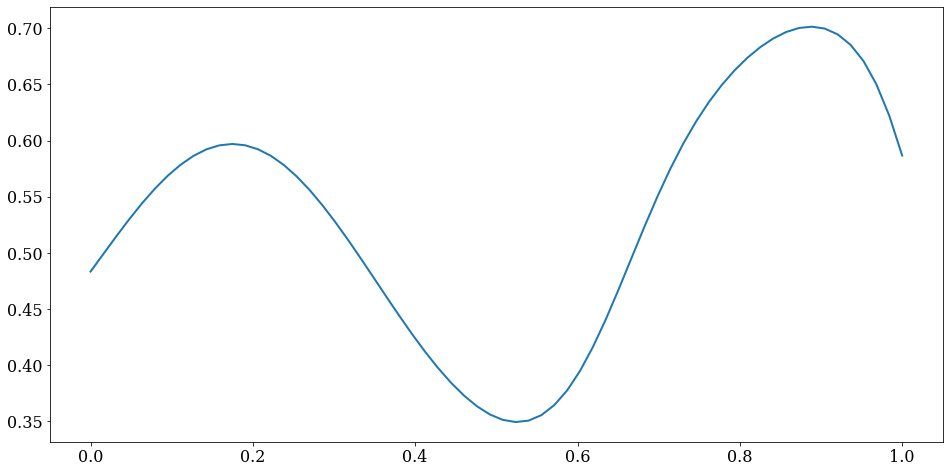

In [ ]:
plt.plot(np.linspace(0,1,64),f(np.linspace(0,1,64)))

#%mldev plot_4

In [ ]:
n_pic = 64*2
a = np.zeros((n_pic,n_pic))
for j in range(n_pic):
    i = int(f(j/n_pic)*n_pic)
    a[i][j] = 1000
    i = int(f(1+j/n_pic)*n_pic)
    a[i][j] = 1000

#%mldev npic

In [ ]:
a = np.diag(np.ones(32))
a = np.concatenate((a,np.zeros((32,32))),axis = 1)
a = np.concatenate((a,np.zeros((32,64))),axis = 0)

#%mldev a

In [ ]:
a[:10,:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
a = np.zeros((128,128))
a[:16,16]

#%mldev a_zeros

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
a[:32,16] = np.ones(32)

#%mldev add_some_ones

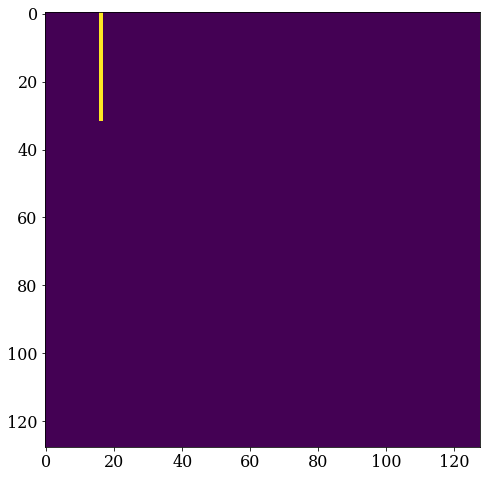

In [ ]:
plt.imshow(a)

#%mldev plot_5

a = np.zeros((64,64))
a[20] = 100

In [ ]:
import functools
import numpy as np
from scipy.special import sph_harm

#%mldev imports_4

In [ ]:
w = sph_harm_to_shtools(sph_harm_transform(a.T))
x = pysh.SHCoeffs.from_array(real(w))

#%mldev wx

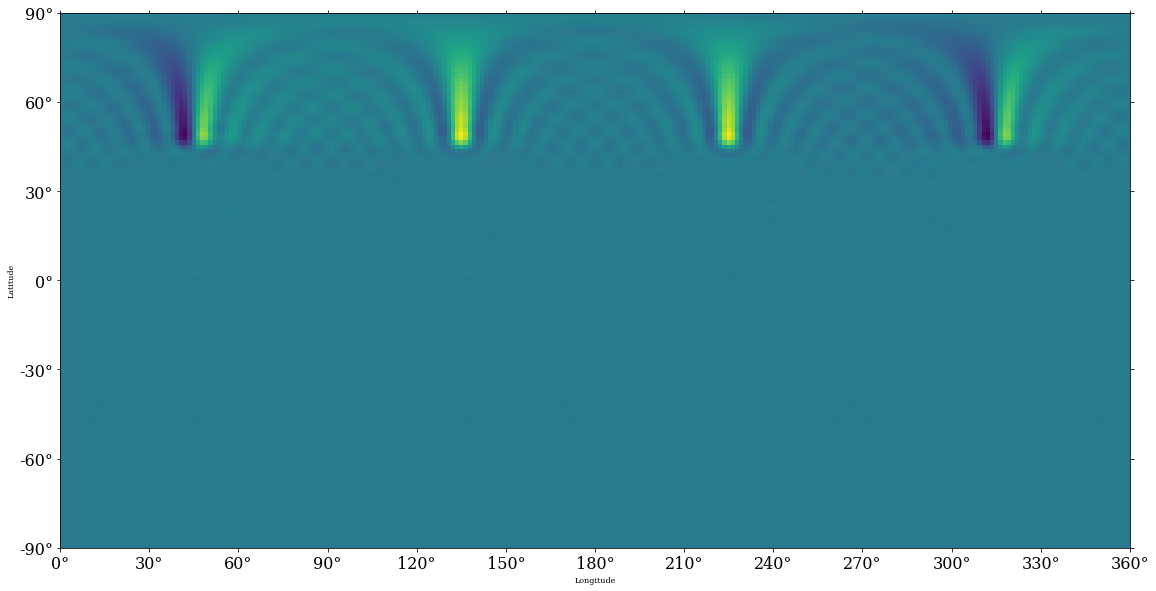

In [ ]:
grid = x.expand()
fig, ax = grid.plot(show=True)

#%mldev grid_fig

# Directional regression

In [ ]:
x = np.array([x_acc]).T #np.array([x_acc_clear]).T
mean = x.mean()
std = x.std()
x = (x - mean) / std

#%mldev xmeanstd

In [ ]:
track_dr, basis_dr = phase_track(x, 600, 3)

#%mldev phase_track_6

Explained variation for 3 principal components: [0.27456685 0.25186656 0.07912414]
Cumulative explained variationfor 3 principal components: 0.6055575499885176



In [ ]:
track_dr_4, basis_dr_4 = phase_track(x, 600, 100)

#%mldev phase_track_4

Explained variation for 100 principal components: [2.74566846e-01 2.51866562e-01 7.91241424e-02 7.83881178e-02
 2.06826673e-02 2.05908599e-02 1.78290698e-02 1.77259356e-02
 1.64920331e-02 1.57026035e-02 1.34263741e-02 1.28837669e-02
 1.22556213e-02 1.22065841e-02 1.08327934e-02 1.06099542e-02
 9.20022773e-03 9.16530095e-03 8.79397114e-03 8.78186844e-03
 8.17032069e-03 8.12591134e-03 7.78016367e-03 7.74974905e-03
 5.95943992e-03 5.87073713e-03 4.40023254e-03 4.38051019e-03
 3.60113535e-03 3.56157514e-03 2.74327079e-03 2.74022737e-03
 2.28908281e-03 2.20516614e-03 2.18840771e-03 2.17081049e-03
 1.69559336e-03 1.68434584e-03 1.66349289e-03 1.66004707e-03
 1.48197974e-03 1.39607735e-03 1.24642537e-03 1.18407570e-03
 1.04735109e-03 9.68826652e-04 9.49223287e-04 9.02499851e-04
 8.33442588e-04 7.58516276e-04 6.94908453e-04 6.28223645e-04
 5.67841975e-04 4.52789143e-04 3.45668674e-04 3.43015476e-04
 3.29918033e-04 2.56110592e-04 2.17160328e-04 1.71220466e-04
 1.64162321e-04 1.52119803e-04 1.41

In [ ]:
X = HankelMatrix(x_acc_clear,300)

#%mldev XHANkel

In [ ]:
pred_X = ApplyDR(TrajectoryToSpherical(track_dr), r = 2)

#%mldev pred_x

In [ ]:
spherical_tr = TrajectoryToSpherical(track_dr)

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

#%mldev dr_trajectory

In [ ]:
fig_2 = go.Figure()


fig_2.add_trace(go.Scatter3d(x=track_dr[:,0][::n],
                             y=track_dr[:,1][::n],
                             z=track_dr[:,2][::n],
                             #mode='markers',
                             marker=dict(
                                         size=2,
                                         line=dict(
                                                    width=0.1
                                                  )

                                         ),
                             name='trajectory'
                            )
                )
fig_2.layout.template = 'plotly_white'
fig_2.show()

fig_2 = go.Figure()
fig_2.add_trace(go.Scatter3d(x=dr_trajectory[:,0][::n],
                             y=dr_trajectory[:,1][::n],
                             z=dr_trajectory[:,-1][::n],
                             #mode='markers',
                             marker=dict(
                                         size=2,
                                         line=dict(
                                                    width=0.1
                                                  )

                                         ),
                             name='dr_trajectory'
                            )
                )


"""fig_2.add_trace(go.Scatter3d(x=[track_dr[0, 0]],
                           y=[track_dr[0, 1]],
                           z=[track_dr[0, 2]],
                           mode='markers',
                           marker_size=10,
                           marker_color='rgba(255, 10, 0, .7)',
                           name='Start point'))

fig_2.add_trace(go.Scatter3d(x=[track_dr[-1, 0]],
                           y=[track_dr[-1, 1]],
                           z=[track_dr[-1, 2]],
                           mode='markers',
                           marker_size=10,
                           marker_color='rgba(10, 250, 250, .7)',
                           name='End point'))"""

fig_2.layout.template = 'plotly_white'
fig_2.show()

#%mldev fig_10

In [ ]:
Sphere_projection(dr_trajectory[:,[0,150,-1]], n = 1)

IndexError: ignored

In [ ]:
Sphere_projection(track_dr, n = 1)

#%mldev Sphere_projection_3

In [ ]:
2 + (4/3)**.5 * 0.1**.5 * 4.5407

3.6580292112424715